# Hand Gesture Recognition - Model Training

## Introduction

This project aims to build a Convolutional Neural Network (CNN) for recognizing Arabic hand gestures.  
The goal is to classify images of hand gestures corresponding to Arabic letters or signs.

### Dataset

The dataset contains images of hands performing various gestures.  
We structured the dataset into three splits:

- `train`: for training the CNN
- `valid`: for validation during training
- `test`: for final evaluation

All images were preprocessed using a **safe enhancement and center-crop pipeline**, which includes:

1. **Noise removal**: Using a Bilateral filter to clean images while keeping edges sharp.
2. **Lighting correction**: Using CLAHE to normalize brightness without affecting skin color.
3. **Edge enhancement**: Slightly boosting edges using Laplacian to make finger boundaries clearer.
4. **Center cropping**: Cropping the center of the image to focus on the hand while removing distracting background.

This preprocessing ensures that the CNN sees consistent and clear images, improving training stability and generalization.

### Objective

The CNN model will learn to recognize hand gestures with high accuracy, while being robust to:

- Different lighting conditions
- Various skin tones
- Slight changes in hand position or background

The training pipeline is designed to avoid **data leakage** by applying the same preprocessing steps to training, validation, and test datasets.

# Import Libraries

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# ======================
# CONFIG
# ======================
IMG = 128
BATCH = 32
EPOCHS = 60

BASE = os.getcwd()
DATA = os.path.join(BASE, "../data", "processed")

In [4]:
# ======================
# DATA GENERATORS
# ======================
def preprocess(img):
    return img / 255.0

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

In [5]:
val_gen = ImageDataGenerator(
    preprocessing_function=preprocess
)

In [6]:
train = train_gen.flow_from_directory(
    os.path.join(DATA, "train"),
    target_size=(IMG, IMG),
    batch_size=BATCH,
    class_mode="categorical"
)

Found 4651 images belonging to 28 classes.


In [7]:
valid = val_gen.flow_from_directory(
    os.path.join(DATA, "valid"),
    target_size=(IMG, IMG),
    batch_size=BATCH,
    class_mode="categorical"
)

Found 870 images belonging to 28 classes.


In [8]:
model = models.Sequential([
    layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=(IMG, IMG, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(train.num_classes, activation="softmax")
])

c:\Users\20100\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463,324 (1.77 MB)

 Trainable params: 462,364 (1.76 MB)

 Non-trainable params: 960 (3.75 KB)

In [11]:
callbacks = [
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=4,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True
    )
]

In [12]:
history = model.fit(
    train,
    validation_data=valid,
    epochs=EPOCHS,
    callbacks=callbacks
)

c:\Users\20100\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
146/146 ━━━━━━━━━━━━━━━━━━━━ 89s 597ms/step - accuracy: 0.0482 - loss: 3.4617 - val_accuracy: 0.0322 - val_loss: 4.0427 - learning_rate: 0.0010
Epoch 2/60
146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 302ms/step - accuracy: 0.0737 - loss: 3.2776 - val_accuracy: 0.0345 - val_loss: 4.0714 - learning_rate: 0.0010
Epoch 3/60
146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 304ms/step - accuracy: 0.1076 - loss: 3.1377 - val_accuracy: 0.0529 - val_loss: 3.5881 - learning_rate: 0.0010
Epoch 4/60
146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 301ms/step - accuracy: 0.1364 - loss: 3.0165 - val_accuracy: 0.0851 - val_loss: 3.6922 - learning_rate: 0.0010
Epoch 5/60
146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 303ms/step - accuracy: 0.1970 - loss: 2.8369 - val_accuracy: 0.0816 - val_loss: 3.3767 - learning_rate: 0.0010
Epoch 6/60
146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 302ms/step - accuracy: 0.2361 - loss: 2.6779 - val_accuracy: 0.2103 - val_loss: 2.9001 - learning_rate: 0.0010
Epoch 7/60
146/146 ━━━━━━━━━━━━━━━━━━━━ 45s 305ms/step - accuracy: 0.2

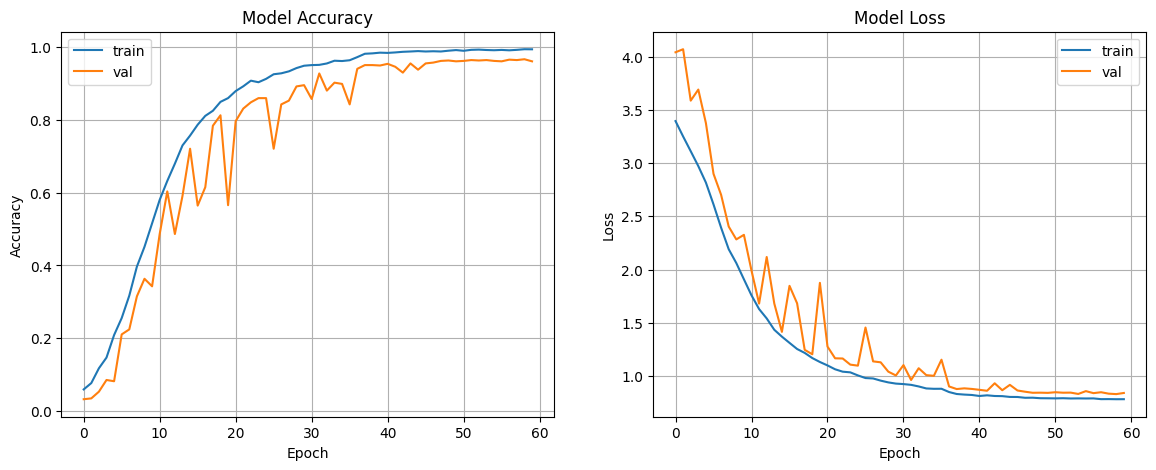

In [13]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_learning_curves(history)

In [14]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess)

test = test_gen.flow_from_directory(
    os.path.join(DATA, "test"),
    target_size=(IMG, IMG),
    batch_size=BATCH,
    class_mode="categorical",
)

model.evaluate(test)

Found 290 images belonging to 28 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.9661 - loss: 0.8114


[0.8373037576675415, 0.9551724195480347]

In [15]:
MODELS_PATH = os.path.join(BASE, "../models", "ArSL_Model_v1.keras")
model.save(MODELS_PATH)

In [17]:
train_no_shuffle = train_gen.flow_from_directory(
    os.path.join(DATA, "train"),
    target_size=(IMG, IMG),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)

train_preds = model.predict(train_no_shuffle)
y_trained_pred = np.argmax(train_preds, axis=1)
y_trained_true = train_no_shuffle.classes

Found 4651 images belonging to 28 classes.


c:\Users\20100\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


146/146 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step


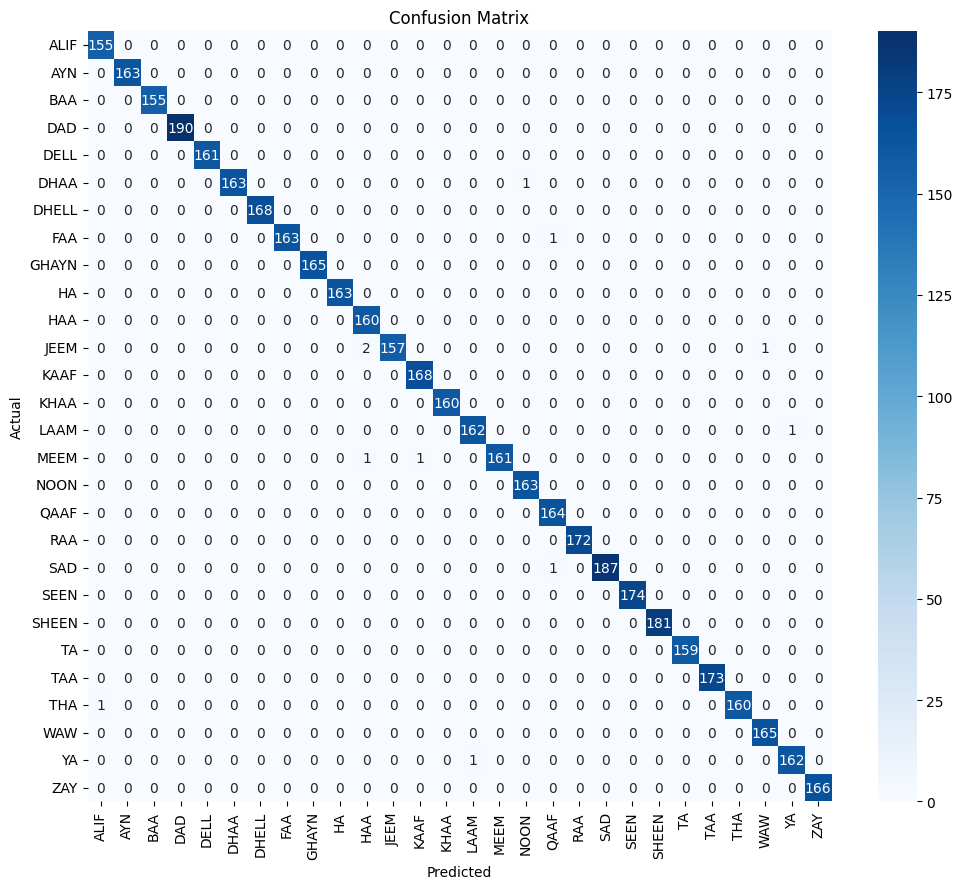

In [18]:
class_names = list(train_no_shuffle.class_indices.keys())

cm = confusion_matrix(y_trained_true, y_trained_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Classification Report
report = classification_report(y_trained_true, y_trained_pred, target_names=class_names)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

        ALIF       0.99      1.00      1.00       155
         AYN       1.00      1.00      1.00       163
         BAA       1.00      1.00      1.00       155
         DAD       1.00      1.00      1.00       190
        DELL       1.00      1.00      1.00       161
        DHAA       1.00      0.99      1.00       164
       DHELL       1.00      1.00      1.00       168
         FAA       1.00      0.99      1.00       164
       GHAYN       1.00      1.00      1.00       165
          HA       1.00      1.00      1.00       163
         HAA       0.98      1.00      0.99       160
        JEEM       1.00      0.98      0.99       160
        KAAF       0.99      1.00      1.00       168
        KHAA       1.00      1.00      1.00       160
        LAAM       0.99      0.99      0.99       163
        MEEM       1.00      0.99      0.99       163
        NOON       0.99      1.00      1.00       163
  

In [20]:
valid_no_Shuffle = val_gen.flow_from_directory(
    os.path.join(DATA, "valid"),
    target_size=(IMG, IMG),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)

Found 870 images belonging to 28 classes.


 1/28 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step

c:\Users\20100\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


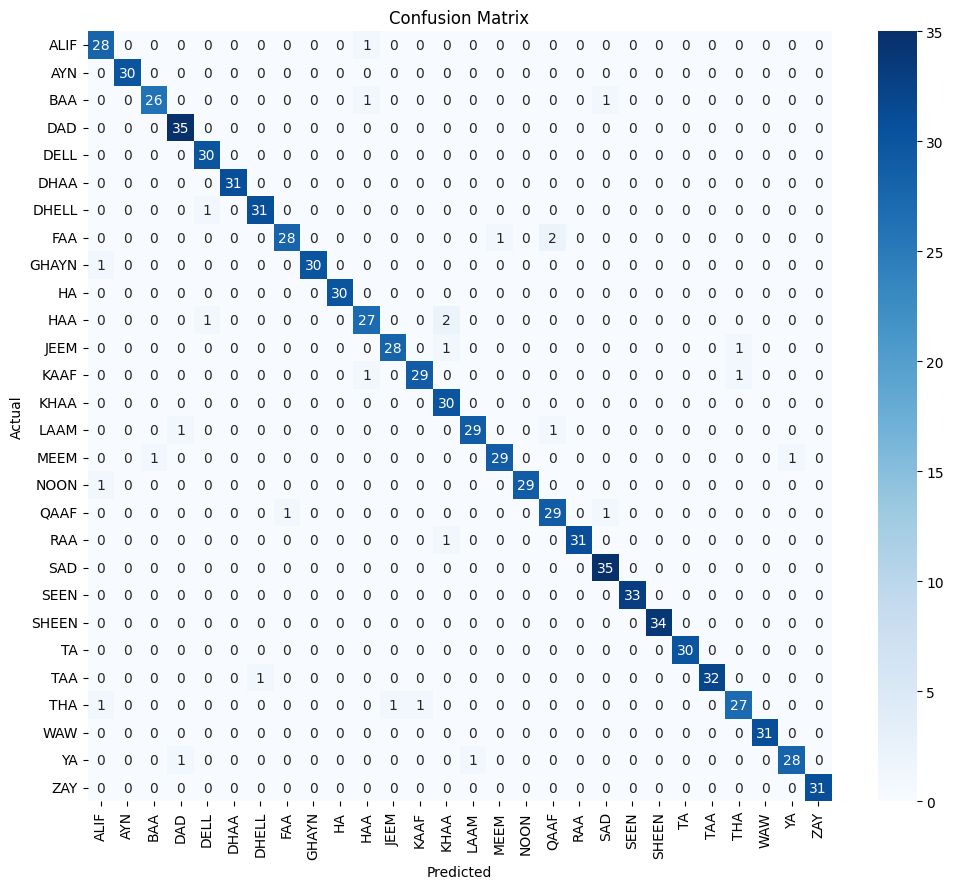

In [21]:
vaild_preds = model.predict(valid_no_Shuffle)
y_valid_pred = np.argmax(vaild_preds, axis=1)
y_valid_true = valid_no_Shuffle.classes
class_names = list(valid_no_Shuffle.class_indices.keys())

cm = confusion_matrix(y_valid_true, y_valid_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Classification Report
report = classification_report(y_valid_true, y_valid_pred, target_names=class_names)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

        ALIF       0.90      0.97      0.93        29
         AYN       1.00      1.00      1.00        30
         BAA       0.96      0.93      0.95        28
         DAD       0.95      1.00      0.97        35
        DELL       0.94      1.00      0.97        30
        DHAA       1.00      1.00      1.00        31
       DHELL       0.97      0.97      0.97        32
         FAA       0.97      0.90      0.93        31
       GHAYN       1.00      0.97      0.98        31
          HA       1.00      1.00      1.00        30
         HAA       0.90      0.90      0.90        30
        JEEM       0.97      0.93      0.95        30
        KAAF       0.97      0.94      0.95        31
        KHAA       0.88      1.00      0.94        30
        LAAM       0.97      0.94      0.95        31
        MEEM       0.97      0.94      0.95        31
        NOON       1.00      0.97      0.98        30
  

In [25]:
test_no_shuffle = test_gen.flow_from_directory(
    os.path.join(DATA, "test"),
    target_size=(IMG, IMG),
    batch_size=BATCH,
    class_mode="categorical",
    shuffle = False
)

Found 290 images belonging to 28 classes.


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

c:\Users\20100\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


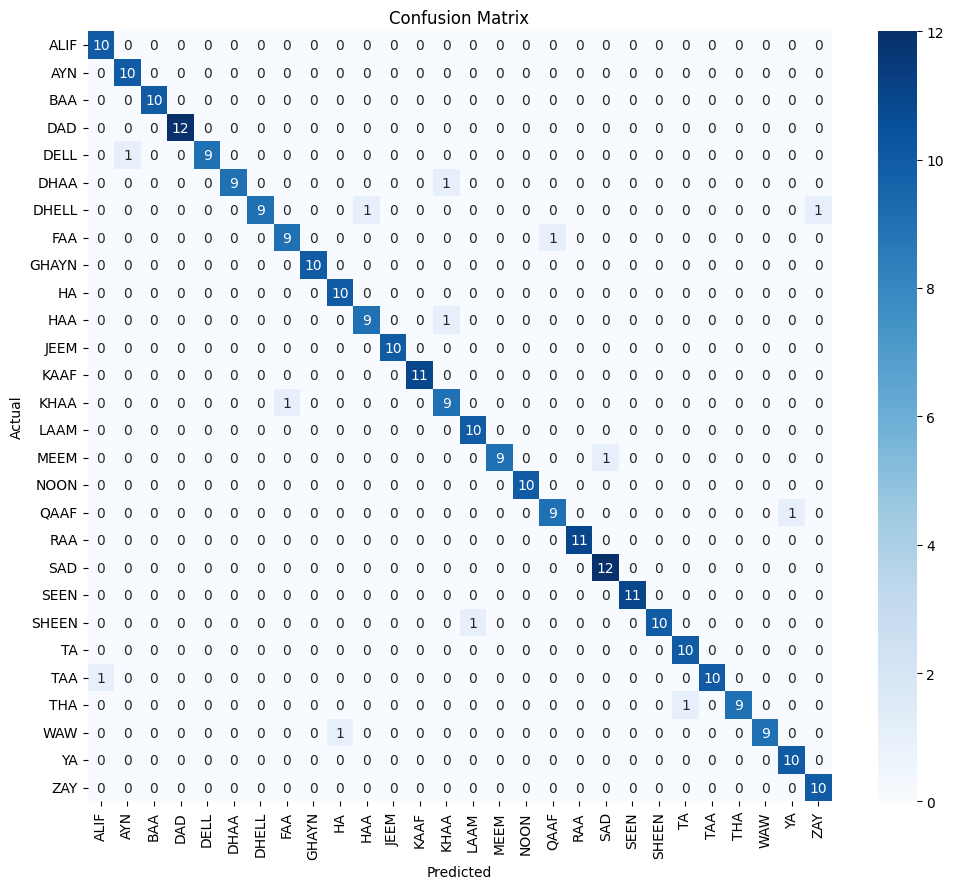

In [26]:
preds = model.predict(test_no_shuffle)
y_pred = np.argmax(preds, axis=1)
y_true = test_no_shuffle.classes
class_names = list(test_no_shuffle.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

        ALIF       0.91      1.00      0.95        10
         AYN       0.91      1.00      0.95        10
         BAA       1.00      1.00      1.00        10
         DAD       1.00      1.00      1.00        12
        DELL       1.00      0.90      0.95        10
        DHAA       1.00      0.90      0.95        10
       DHELL       1.00      0.82      0.90        11
         FAA       0.90      0.90      0.90        10
       GHAYN       1.00      1.00      1.00        10
          HA       0.91      1.00      0.95        10
         HAA       0.90      0.90      0.90        10
        JEEM       1.00      1.00      1.00        10
        KAAF       1.00      1.00      1.00        11
        KHAA       0.82      0.90      0.86        10
        LAAM       0.91      1.00      0.95        10
        MEEM       1.00      0.90      0.95        10
        NOON       1.00      1.00      1.00        10
  